# PDG Python API Tutorial

## Introduction

This tutorial provides a set of examples that illustrate the main features of the PDG Python API. Comprehensive documentation is available at https://pdgapi.lbl.gov/doc/pythonapi.html.

## Installation

To ensure any dependencies are installed in a self-contained environment, we first create a new Python virtual environment and activate it:

```bash
python -m venv ~/pdg.venv
source ~/pdg.venv/bin/activate
```
Now install the PDG Python API package `pdg`:

```bash
pip install pdg
```

In order to run the examples in this notebook, some additional packages are required:

```bash
pip install numpy matplotlib jupyter
```

You can now launch a Jupyter session (`jupyter lab`) and open this notebook.

## Preamble

The examples that follow assume that the following code was run to import dependencies and create an instance of the PDG API:

In [1]:
import pdg
import matplotlib.pyplot as plt
import numpy as np

api = pdg.connect()

The last line creates an instance of the PDG API that is connected to the default [PDG database](https://pdgapi.lbl.gov/doc/schema.html) that was installed when the `pdg` package was installed. This database contains the data from the edition of the *Review of Particle Physics* that was current at the time the installed version of the `pdg` package was released. We can easily see which version this is by printing the `api` instance:

In [2]:
print(api)

2024 Review of Particle Physics, data release 2025-04-14 13:53:03 PDT, API version 0.1.4
S. Navas et al. (Particle Data Group), Phys. Rev. D 110, 030001 (2024)
(C) Particle Data Group (PDG), data released under CC BY 4.0
For further information see https://pdg.lbl.gov/api


## An appetizer

Before we run through the fundamentals, let's take a look at a practical example that demonstrates one of the main new things offered by the PDG API, namely, programmatic access to branching fractions:

In [3]:
for bf in api.get_particle_by_name('K+').exclusive_branching_fractions():
    if not bf.is_limit:
        print(f'{bf.description:35} {bf.value:7g}')

K+ --> e+ nu_e                      1.58167e-05
K+ --> mu+ nu_mu                    0.635603
K+ --> pi0 e+ nu_e                  0.050719
K+ --> pi0 mu+ nu_mu                0.0335166
K+ --> pi0 pi0 e+ nu_e              2.54928e-05
K+ --> pi+ pi- e+ nu_e              4.24664e-05
K+ --> pi+ pi- mu+ nu_mu            1.43495e-05
K+ --> pi+ pi0                      0.206705
K+ --> pi+ pi0 pi0                  0.0175965
K+ --> pi+ pi+ pi-                  0.0558348
K+ --> mu+ nu_mu gamma              0.00615882
K+ --> mu+ nu_mu gamma (SD**+)      1.33e-05
K+ --> e+ nu_e gamma                1.02858e-05
K+ --> pi0 e+ nu_e gamma            0.000269809
K+ --> pi0 mu+ nu_mu gamma          1.24769e-05
K+ --> pi+ pi0 gamma (INT)          -4.24e-06
K+ --> pi+ pi0 gamma (DE)           5.99e-06
K+ --> pi+ pi0 e+ e-                4.24e-06
K+ --> pi+ pi0 pi0 gamma            7.56649e-06
K+ --> pi+ pi+ pi- gamma            7.12567e-06
K+ --> pi+ gamma gamma              1.00599e-06
K+ --> pi+ e+ e- ga

This should be pretty self explanatory: We're just printing the exclusive branching fractions of the $K^+$. We'll show some other practical examples soon, but first, let's quickly go over the basics.

## The basics

### Getting a particle

Particles are represented by the `PdgParticle` class. There are multiple ways to get a particle from the API. Depending on the method, the result can be a Python list of `PdgParticle`s, a wrapped `PdgParticleList`, or a specific `PdgParticle`.

#### By name

A particle name can refer to a single particle or to a group of them. The function `get_particle_by_name` will return a `PdgParticle` if there's a unique match, and will raise an exception if not. The function `get_particles_by_name` (note the plural) always returns a list of `PdgParticles`. Aliases will automatically be resolved.

In [4]:
api.get_particle_by_name('pi+')

PdgParticle('S008/2024', name='pi+')

In [5]:
api.get_particles_by_name('pi')

[PdgParticle('S008/2024', name='pi-'),
 PdgParticle('S009/2024', name='pi0'),
 PdgParticle('S008/2024', name='pi+')]

#### By MC ID

Since MC IDs are unambiguous, `get_particle_by_mcid` returns a `PdgParticle` directly.

In [6]:
api.get_particle_by_mcid(2212)

PdgParticle('S016/2024', name='p')

#### By PDG Identifier

PDG Identifiers identify quantities evaluated by PDG. They loosely correspond to pages in [pdgLive](https://pdglive.lbl.gov), where they are shown on relevant pages and appear in the URL. A PDG Identifier can refer to, e.g., a particle, or a set of measurements (e.g. masses) for a particle, or more general measurements, such as mixing angles or SUSY limits. The return value from `get` will always be an instance of a `PdgData` subclass; these subclasses include `PdgParticle`, the generic `PdgProperty` class, and `PdgMass`, `PdgWidth`, and`PdgLifetime` (the three of which are all subclasses of `PdgProperty`). Since there can be multiple "particles" (e.g. charge states) associated with a given identifier, `get` will never return a `PdgParticle` directly, but instead will return a `PdgParticleList`, which inherits from both `PdgData` and the Python `list` class; its elements are the individual `PdgParticle` objects.

In [7]:
plist = api.get('S008/2024')
plist

PdgParticleList('S008/2024')

To pretty-print the contents of this `PdgParticleList`, we can simply cast it to a Python `list`.

In [8]:
list(plist)

[PdgParticle('S008/2024', name='pi+'), PdgParticle('S008/2024', name='pi-')]

### Getting quantum numbers

Quantum numbers are associated directly with a `PdgParticle` and can always be accessed as attributes.

In [9]:
p = api.get_particle_by_name('pi0')
p.charge, p.quantum_I, p.quantum_G, p.quantum_J, p.quantum_P, p.quantum_C

(0.0, '1', '-', '0', '-', '+')

In [10]:
p = api.get_particle_by_name('pi+')
p.charge, p.quantum_I, p.quantum_G, p.quantum_J, p.quantum_P, p.quantum_C

(1.0, '1', '-', '0', '-', None)

### Getting masses, widths, and lifetimes

Masses, widths, and lifetimes are the main particle properties provided by the API. In some cases there may be multiple identifiers for masses (or widths or lifetimes) for a given particle, corresponding to different techniques or assumptions. A given particle may have width or lifetime properties, but not both.

The `masses`, `widths`, and `lifetimes` methods provide iterators over these properties.

In [11]:
p = api.get_particle_by_name('pi+')
list(p.masses())

[PdgMass('S008M/2024')]

In [12]:
list(p.widths())

[]

In [13]:
list(p.lifetimes())

[PdgLifetime('S008T/2024')]

Since `PdgMass`, `PdgWidth`, and `PdgLifetime` classes are all subclasses of `PdgProperty`, they all provide a `summary_values` function that produces a list of `SummaryTableValue` objects:

In [14]:
m = api.get('S008M')
m

PdgMass('S008M/2024')

In [15]:
m.summary_values()

[{'id': 297247,
  'pdgid_id': 1787,
  'pdgid': 'S008M',
  'edition': '2024',
  'value_type': 'FC',
  'in_summary_table': True,
  'confidence_level': None,
  'limit_type': None,
  'comment': None,
  'value': 139.570390983681,
  'error_positive': 0.00018200716040826,
  'error_negative': 0.00018200716040826,
  'scale_factor': 1.76094,
  'unit_text': 'MeV',
  'display_value_text': '139.57039+-0.00018',
  'display_power_of_ten': 0,
  'display_in_percent': False,
  'sort': 1,
  'description': 'pi+- MASS'},
 {'id': 297248,
  'pdgid_id': 1787,
  'pdgid': 'S008M',
  'edition': '2024',
  'value_type': 'AC',
  'in_summary_table': False,
  'confidence_level': None,
  'limit_type': None,
  'comment': None,
  'value': 139.570390983681,
  'error_positive': 0.000169358969894129,
  'error_negative': 0.000169358969894129,
  'scale_factor': 1.638568,
  'unit_text': 'MeV',
  'display_value_text': '139.57039+-0.00017',
  'display_power_of_ten': 0,
  'display_in_percent': False,
  'sort': 2,
  'description'

Human-readable information on summary values is available via attributes:

In [16]:
sv = m.summary_values()
sv[0].value_type, sv[1].value_type

('OUR FIT', 'OUR AVERAGE')

In this case, we see that two summary values are provided for `S008M`, corresponding to the PDG fit and average.

A given summary value is encoded in whatever units are considered most appropriate. The encoded value and units can be accessed via the `value` and `units` attributes. The `get_value` method can be used to get the value in specified units.

In [17]:
v = m.summary_values()[0]

v.value, v.units, v.get_value('GeV')

(139.570390983681, 'MeV', 0.139570390983681)

The `error`, `error_positive`, and `error_negative` attributes, and the `get_error` method, are analogous:

In [18]:
v.error, v.error_positive, v.error_negative, v.get_error('GeV')

(0.00018200716040826,
 0.00018200716040826,
 0.00018200716040826,
 1.8200716040826e-07)

For convenience, the `mass`, `width`, and `lifetime` attributes of a `PdgParticle` can be used to get the "best" (i.e. first) summary value, in standard units of GeV and seconds. Normally, widths and lifetimes are automatically interconverted when necessary. (In "pedantic" mode, described at the end of this tutorial, this conversion does not occur, and there must be exactly one matching property identifier and summary value, or a `PdgNoDataError` will be thrown.)

In [19]:
p.mass, p.width, p.lifetime

(0.139570390983681, 2.5283166082854017e-17, 2.60331319994913e-08)

The top quark provides an example where there are multiple mass properties:

In [20]:
p = api.get_particle_by_name('t')

list(p.masses())

[PdgMass('Q007TP/2024'), PdgMass('Q007TP2/2024'), PdgMass('Q007TP4/2024')]

In [21]:
[m.description for m in p.masses()]

['t-Quark Mass (Direct Measurements)',
 't-Quark Mass from Cross-Section Measurements',
 't-Quark Pole Mass from Cross-Section Measurements']

### Getting decays

In addition to masses and widths/lifetimes, a particle can have one or more branching fraction properties (which are either inclusive or exclusive):

In [22]:
p = api.get_particle_by_name('pi+')

We can easily get all of the branching fractions of the $\pi^+$:

In [23]:
list(p.branching_fractions())

[PdgBranchingFraction('S008.1/2024', "pi+ --> mu+ nu_mu"),
 PdgBranchingFraction('S008.3/2024', "pi+ --> mu+ nu_mu gamma"),
 PdgBranchingFraction('S008.2/2024', "pi+ --> e+ nu_e"),
 PdgBranchingFraction('S008.5/2024', "pi+ --> e+ nu_e gamma"),
 PdgBranchingFraction('S008.4/2024', "pi+ --> e+ nu_e pi0"),
 PdgBranchingFraction('S008.6/2024', "pi+ --> e+ nu_e e+ e-"),
 PdgBranchingFraction('S008.11/2024', "pi+ --> mu+ nu_mu nu nubar"),
 PdgBranchingFraction('S008.10/2024', "pi+ --> e+ nu_e nu nubar"),
 PdgBranchingFraction('S008.7/2024', "pi+ --> mu+ nubar_e"),
 PdgBranchingFraction('S008.8/2024', "pi+ --> mu+ nu_e"),
 PdgBranchingFraction('S008.9/2024', "pi+ --> mu- e+ e+ nu")]

In this case, they're all exclusive:

In [24]:
list(p.inclusive_branching_fractions())

[]

Taking the first decay:

In [25]:
decay = next(p.exclusive_branching_fractions())
decay

PdgBranchingFraction('S008.1/2024', "pi+ --> mu+ nu_mu")

We can get its description:

In [26]:
decay.description

'pi+ --> mu+ nu_mu'

And the summary values for the branching fraction itself:

In [27]:
decay.summary_values()

[{'id': 297269,
  'pdgid_id': 2247,
  'pdgid': 'S008.1',
  'edition': '2024',
  'value_type': 'V',
  'in_summary_table': True,
  'confidence_level': None,
  'limit_type': None,
  'comment': None,
  'value': 0.999877,
  'error_positive': 4e-07,
  'error_negative': 4e-07,
  'scale_factor': None,
  'unit_text': '',
  'display_value_text': '(99.98770+-0.00004)%',
  'display_power_of_ten': 0,
  'display_in_percent': False,
  'sort': 1,
  'description': 'pi+ --> mu+ nu_mu'}]

Going further, we can inspect the products of the decay:

In [28]:
products = decay.decay_products
products

[PdgDecayProduct(item='mu+', multiplier=1, subdecay=None),
 PdgDecayProduct(item='nu_mu', multiplier=1, subdecay=None)]

In [29]:
products[0].item, products[0].multiplier, products[0].subdecay

(PdgItem("mu+"), 1, None)

Here, an `item` (represented by the `PdgItem` class) corresponds to an individual "token" in a decay description. Items can refer directly to particles, or can be aliases thereof, or can be generic items (e.g. "leptons"), or more general descriptive text:

In [30]:
item = products[0].item

In [31]:
item.name, item.item_type, item.has_particle, item.particle

('mu+', 'P', True, PdgParticle('S004/2024', name='mu+'))

## Some examples

Having covered the basics, let's dive into some more interesting examples.

### Printing all $B^0$ decays that produce a $J/\psi$

In [32]:
p = api.get_particle_by_name('B0')
# The "canonical" name of the particle should be used for comparisons:
jpsi_name = api.get_canonical_name('J/psi')
# For the J/psi the canonical name is J/psi(1S)

for decay in p.exclusive_branching_fractions():
    for decay_product in decay.decay_products:
        item = decay_product.item
        # A decay product's PdgItem may be associated with a specific particle,
        # but may also be something more generic (e.g. "leptons"). If has_particle
        # is True, we can retrieve the associated PdgParticle via the particle property.
        if item.has_particle and item.particle.name == jpsi_name:
            print(f'{decay.description:65s} {decay.display_value_text}')

B0 --> J/psi(1S) K0                                               (8.91+-0.21)E-4
B0 --> J/psi(1S) K+ pi-                                           (1.15+-0.05)E-3
B0 --> J/psi(1S) eta K0S                                          (5.4+-0.9)E-5
B0 --> J/psi(1S) eta^' K0S                                        <2.5E-5
B0 --> J/psi(1S) phi K0                                           (4.9+-1.0)E-5
B0 --> J/psi(1S) omega K0                                         (2.3+-0.4)E-4
B0 --> J/psi(1S) K(1270)0                                         (1.3+-0.5)E-3
B0 --> J/psi(1S) pi0                                              (1.66+-0.10)E-5
B0 --> J/psi(1S) eta                                              (1.08+-0.23)E-5
B0 --> J/psi(1S) pi+ pi-                                          (3.99+-0.15)E-5
B0 --> J/psi rho(1700)0 , rho()0 --> pi+ pi-                      (2.0+-1.3)E-6
B0 --> J/psi(1S) omega                                            (1.8+0.7-0.5)E-5
B0 --> J/psi(1S) K+ K-           

**Exercise:** Find all D+ decays that produce a $K^+$ and exactly one other particle. How many have a branching fraction of > 0.1%?

In [33]:
p = api.get_particle_by_name('D+')
kplus_name = api.get_canonical_name('K+')
decays, n_above_1pct = [], 0
for decay in p.exclusive_branching_fractions():
    product_names = [prod.item.name for prod in decay.decay_products]
    if kplus_name in product_names:
        decays.append(decay)
        if decay.value > 0.001:
            n_above_1pct += 1

decays, n_above_1pct

([PdgBranchingFraction('S031.59/2024', "D+ --> K+ 2K0S"),
  PdgBranchingFraction('S031.227/2024', "D+ --> K+ K- K0S pi+"),
  PdgBranchingFraction('S031.16/2024', "D+ --> K0S K+"),
  PdgBranchingFraction('S031.299/2024', "D+ --> K0L K+"),
  PdgBranchingFraction('S031.298/2024', "D+ --> K0S K+ pi0"),
  PdgBranchingFraction('S031.300/2024', "D+ --> K0L K+ pi0"),
  PdgBranchingFraction('S031.4/2024', "D+ --> K+ K- pi+"),
  PdgBranchingFraction('S031.335/2024', "D+ --> K+ K- pi+ pi0"),
  PdgBranchingFraction('S031.324/2024', "D+ --> K0S K+ eta"),
  PdgBranchingFraction('S031.134/2024', "D+ --> K+ K0S pi+ pi-"),
  PdgBranchingFraction('S031.336/2024', "D+ --> K0S K+ pi0 pi0"),
  PdgBranchingFraction('S031.88/2024', "D+ --> K+ K- 2pi+ pi-"),
  PdgBranchingFraction('S031.234/2024', "D+ --> K+ pi0"),
  PdgBranchingFraction('S031.268/2024', "D+ --> K+ eta"),
  PdgBranchingFraction('S031.269/2024', "D+ --> K+ eta^'(958)"),
  PdgBranchingFraction('S031.357/2024', "D+ --> K+ 2pi0"),
  PdgBranchingF

### Plotting masses of all decay products of the $D^+$

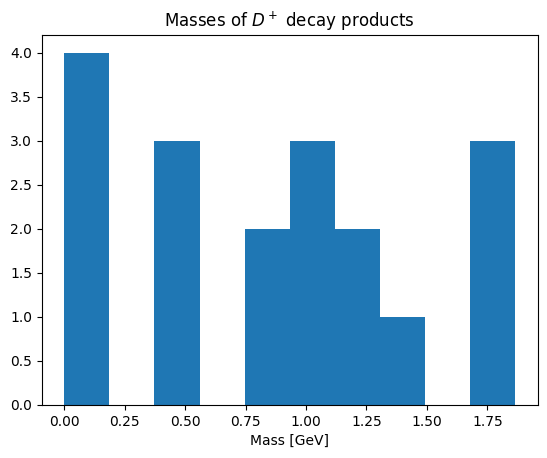

In [34]:
all_masses = set()
p = api.get_particle_by_name('D+')
for decay in p.exclusive_branching_fractions():
    for prod in decay.decay_products:
        if not prod.item.has_particle:
            continue
        if prod.item.particle.has_mass_entry:
            # Since a mass entry could be a limit, rather than a measurement,
            # we must perform a check:
            if prod.item.particle.mass is not None:
                all_masses.add(prod.item.particle.mass)
plt.hist(all_masses);
plt.xlabel('Mass [GeV]')
plt.title('Masses of $D^+$ decay products');

**Exercise:** Create a 2D plot of mass vs lifetime for the $D^+$'s decay products

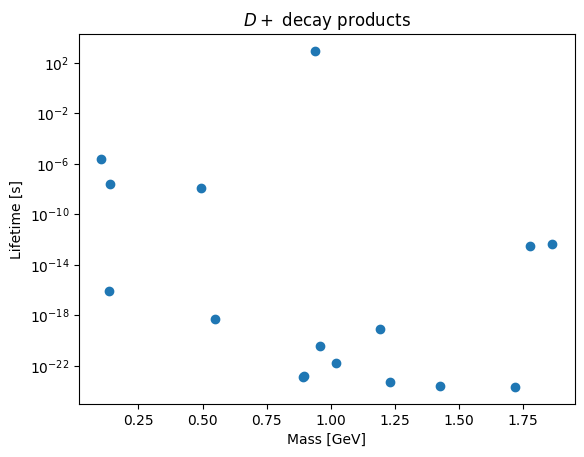

In [35]:
masses, lifetimes = [], []
p = api.get_particle_by_name('D+')
for decay in p.exclusive_branching_fractions():
    for prod in decay.decay_products:
        if not prod.item.has_particle:
            continue
        if not prod.item.particle.has_mass_entry:
            continue
        mass, lifetime = prod.item.particle.mass, prod.item.particle.lifetime
        if mass and lifetime and (mass not in masses):
            masses.append(prod.item.particle.mass)
            lifetimes.append(prod.item.particle.lifetime)

plt.scatter(masses, lifetimes)
plt.yscale('log')
plt.title('$D+$ decay products')
plt.xlabel('Mass [GeV]')
plt.ylabel('Lifetime [s]');

### Plotting $K^+$ mass over time

For this, you will need to download a PDG database file that contains historical data in addition to the data from the current edition. See https://pdg.lbl.gov/2024/api/index.html.

In [36]:
api_all = pdg.connect("sqlite:///pdgall-2024-v0.1.4.sqlite")

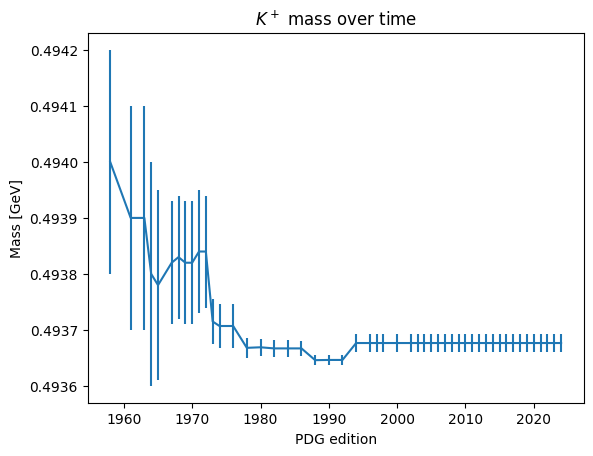

In [37]:
xs, ys, yerrs = [], [], []
for edition in api_all.editions:
    p = api_all.get_particle_by_name('K+', edition=edition)
    if p.has_mass_entry and p.mass is not None:
        xs.append(int(edition))
        ys.append(p.mass)
        yerrs.append(p.mass_error)

plt.errorbar(xs, ys, yerrs)
plt.xlabel('PDG edition')
plt.ylabel('Mass [GeV]')
plt.title('$K^+$ mass over time');

**Exercise:** Find the year in which the pentaquark state $P_{c\bar c}(4312)^+$ first had a mass entry. (Hint: This state has the PDG identifier `B185`, as indicated on pdgLive. It can also be looked up under the name `P_{c cbar}(4312)+`.)

In [38]:
min_edition = 9999
for edition in api_all.editions:
    if api_all.get('B185', edition=edition)[0].has_mass_entry:
        if int(edition) < min_edition:
            min_edition = int(edition)

min_edition

2020

### Printing all neutrino mixing properties

Neutrino mixing properties all live under the `S067` parent identifier (as can be seen, for example, by browsing pdgLive). Let's print them all:

In [39]:
parent = api.get('S067')
for prop in parent.get_children():
    if prop.has_best_summary():
        print(f'{prop.baseid:10s} {prop.value:8f} {prop.description}')

S067SDN    0.033000 Day-Night Asymmetry (B8)
S067DEL    1.186745 delta, CP violating phase
S067P13    0.021866 sin**2(theta(13))
S067DM1    -0.002529 Deltam(32)**2
S067P23    0.552989 sin**2(theta(23))
S067DM3    0.000075 Deltam(21)**2
S067P12    0.307000 sin**2(theta(12))
S067CP2    -0.000120 <Deltamass**2(32)-Deltambar(32)**2>
S067CPT    0.000110 <Deltamass**2(21)-Deltambar(21)**2>


**Exercise:** Now do the same for the $b$-related CKM elements. (Hint: See PDG Identifier `S052`.)

In [40]:
parent = api.get('S052')
for prop in parent.get_children():
    if prop.has_best_summary():
        print(f'{prop.baseid:10s} {prop.value:8f} {prop.description}')

S052A00    0.041400 |V(cb)| (from D_s*- mu+ nu_mu)
S052CB1    0.035340 |V_(cb)| * F(1) (from B0 --> D*- lepton+ nu)
S052CB2    0.041210 |V_(cb)| * G(1) (from B --> D- lepton+ nu)


### Getting the limit on $K_L \to \pi^0 \nu \bar\nu$

In [41]:
p = api.get_particle_by_name('K(L)0')
products = ['pi0', 'nu', 'nubar']
decay = None
for this_decay in p.exclusive_branching_fractions():
    these_products = [product.item.name for product in this_decay.decay_products]
    if sorted(these_products) == sorted(products):
        decay = this_decay
        break

In [42]:
decay

PdgBranchingFraction('S013.43/2024', "K0L --> pi0 nu nubar")

In [43]:
decay.best_summary()

{'id': 299313,
 'pdgid_id': 19797,
 'pdgid': 'S013.43',
 'edition': '2024',
 'value_type': 'D',
 'in_summary_table': True,
 'confidence_level': 90.0,
 'limit_type': 'U',
 'comment': None,
 'value': 3e-09,
 'error_positive': 0.0,
 'error_negative': 0.0,
 'scale_factor': None,
 'unit_text': '',
 'display_value_text': '<3.0E-9',
 'display_power_of_ten': 0,
 'display_in_percent': False,
 'sort': 1,
 'description': 'K0L --> pi0 nu nubar'}

### Neutralino properties

SUSY properties live under the PDG Identifier `S046` (as indicated on e.g. pdgLive). Let's do a quick search for those that may be related to neutralinos:

In [44]:
parent = api.get('S046')
props = [p for p in parent.get_children() if 'neutralino' in p.description.lower()]

In [45]:
props

[PdgMass('S046ZNO/2024'), PdgProperty('S046UPH/2024')]

In [46]:
[p.description for p in props]

['chitilde_20, chitilde_30, chitilde_40 (Neutralinos) mass limits',
 'Unstable chitilde_10 (Lightest Neutralino) mass limit']

In [47]:
props[0].best_summary()

### Muon anomalies

Let's look for anomalous properties of the muon.

In [48]:
muon = api.get_particle_by_name('mu-')
props = [p for p in muon.get_children() if 'anomaly' in p.description.lower()]

In [49]:
props

[PdgProperty('S004MEC/2024')]

In [50]:
props[0].description

'MUON-ELECTRON CHARGE RATIO ANOMALY q(mu+)/q(e-) + 1'

In [51]:
props[0].best_summary()

{'id': 296449,
 'pdgid_id': 10107,
 'pdgid': 'S004MEC',
 'edition': '2024',
 'value_type': 'AC',
 'in_summary_table': True,
 'confidence_level': None,
 'limit_type': None,
 'comment': None,
 'value': 1.1e-09,
 'error_positive': 2.1e-09,
 'error_negative': 2.1e-09,
 'scale_factor': 1.0,
 'unit_text': '',
 'display_value_text': '(1.1+-2.1)E-9',
 'display_power_of_ten': 0,
 'display_in_percent': False,
 'sort': 1,
 'description': 'MUON-ELECTRON CHARGE RATIO ANOMALY q(mu+)/q(e-) + 1'}

Our crude search did not yield $g-2$, but a quick glance at pdgLive will reveal that `S004MM` is the identifier for it: 

In [52]:
api.get('S004MM').best_summary()

{'id': 296446,
 'pdgid_id': 10074,
 'pdgid': 'S004MM',
 'edition': '2024',
 'value_type': 'AC',
 'in_summary_table': True,
 'confidence_level': None,
 'limit_type': None,
 'comment': None,
 'value': 0.00116592059,
 'error_positive': 2.2e-10,
 'error_negative': 2.2e-10,
 'scale_factor': 1.0,
 'unit_text': '',
 'display_value_text': '0.00116592059+-0.00000000022',
 'display_power_of_ten': -10,
 'display_in_percent': False,
 'sort': 1,
 'description': 'mu_mu/(ehbar/2m_mu)-1 = (g_mu-2)/2'}

## Wrapping up

### Pedantic mode

Before we close, there's one important feature of the API that bears mentioning: *pedantic mode*. In pedantic mode, the API will not automatically choose the "best" property or summary value when multiple options are available. Instead, an exception will be thrown in such situations.

For example, we saw earlier that the top quark has three mass properties. Outside of pedantic mode, the API will choose the "best" (first) option:

In [53]:
top = api.get_particle_by_name('t')
list(top.masses())

[PdgMass('Q007TP/2024'), PdgMass('Q007TP2/2024'), PdgMass('Q007TP4/2024')]

In [54]:
top.mass

172.574693096886

In pedantic mode, this is not the case:

In [55]:
api_pedantic = pdg.connect(pedantic=True)

try:
    api_pedantic.get_particle_by_name('t').mass
except Exception as e:
    print(type(e), e)

<class 'pdg.errors.PdgAmbiguousValueError'> Ambiguous best property for t mass (Q007/2024)


In such a situation, pedantic mode will require youto be explicit about which mass you want:

In [56]:
api_pedantic.get('Q007TP').best_summary().get_value('GeV')

172.574693096886

### Closing words

This concludes our tour of the PDG API. Thanks for following along! We hope that you are now positioned to start making use of the API, and we welcome your feedback, either by contacting PDG at api@pdg.lbl.gov or by opening an issue on [github](https://github.com/particledatagroup/api).